In [28]:
from os import getcwd, path
from PIL import Image
import IPython
import base64
import imageio
import io

import numpy as np
import matplotlib.pyplot as plt

import gym
from tensorflow.keras import Sequential, optimizers, initializers, layers
from tf_agents.networks.q_network import QNetwork
from tf_agents.agents.dqn.dqn_agent import DqnAgent
from tf_agents.specs import ArraySpec
from tf_agents.environments import suite_gym, TFPyEnvironment, py_environment
from tf_agents.utils import common
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.trajectories import trajectory, TimeStep
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer


## global constant

In [2]:
DEBUG = True
TRAIN = True

# N_EPISODES = 1
N_EPISODES = 8
EPISODES_PER_LOG = 10
EPISODES_PER_SAVE = 500
MAX_STEPS_PER_EPISODE = 100000

FRAME_SKIP = 4
DISCOUNT_RATE = 0.99
LEARNING_RATE = 1e-7
MOMENTUM = 0.95
EPSILON = 1.0
EPSILON_MIN = 0.1
BATCH_SIZE = 32
REPLAY_BUFFER_MAX_LENGTH = 1000


### helpers

In [3]:
# region
def epsilon(step):
    return max(EPSILON_MIN, EPSILON * (1 - step / MAX_STEPS_PER_EPISODE))


def next_frame(env, policy, append):
    time_step = env.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = env.step(action_step.action)
    traj = trajectory.from_transition(time_step,
                                      action_step,
                                      next_time_step)

    # Add trajectory to the replay buffer
    append(traj)

    return time_step


def embed_gif(gif_buffer):
    tag = f"<img src=\"data:image/gif;base64,{base64.b64encode(gif_buffer).decode()}\"/>"
    return IPython.display.HTML(tag)


def run_episodes_and_create_video(policy, eval_tf_env, eval_py_env):
    num_episodes = 3
    frames = []
    for _ in range(num_episodes):
        time_step = eval_tf_env.reset()
        frames.append(eval_py_env.render())
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = eval_tf_env.step(action_step.action)
            frames.append(eval_py_env.render())
    gif_file = io.BytesIO()
    imageio.mimsave(gif_file, frames, format='gif', fps=60 / FRAME_SKIP)
    IPython.display.display(embed_gif(gif_file.getvalue()))
# endregion


# by screen


In [32]:
# open the assualt environment (with image)
# AtariPreprocessing downsamples to 84x84, turns greyscale, and implements frame skipping
py_env = AtariPreprocessing(gym.make('Assault-v0'),
                            frame_skip=FRAME_SKIP,
                            terminal_on_life_loss=True,
                            screen_size=84)
train_env = TFPyEnvironment(suite_gym.wrap_env(py_env))


In [12]:
q_net = QNetwork(train_env.observation_spec(),
                 train_env.action_spec(),

                 # The rescales the values to a range of [-1, 1]
                 preprocessing_layers=layers.Rescaling(scale=1./127.5,
                                                       offset=-1),
                 conv_layer_params=[(32, (8, 8), (4, 4)),
                                    (64, (4, 4), (2, 2)),
                                    (64, (3, 3), (1, 1))],
                 fc_layer_params=(512, 7),

                 kernel_initializer=initializers.VarianceScaling(scale=2.0,
                                                                 mode='fan_in',
                                                                 distribution='truncated_normal'))

agent = DqnAgent(train_env.time_step_spec(),
                 train_env.action_spec(),
                 q_network=q_net,

                 epsilon_greedy=lambda: epsilon(
                     agent.train_step_counter.numpy()),

                 gamma=DISCOUNT_RATE,
                 optimizer=optimizers.SGD(LEARNING_RATE,
                                          MOMENTUM,
                                          nesterov=True))

agent.initialize()
agent.train = common.function(agent.train)


In [13]:
# implement replay buffer
replay_buffer = TFUniformReplayBuffer(agent.collect_data_spec,
                                      batch_size=1,
                                      max_length=REPLAY_BUFFER_MAX_LENGTH)

next_frame(train_env,
           RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec()),
           replay_buffer.add_batch)

experience_batches = iter(replay_buffer.as_dataset(num_steps=2,
                                                   sample_batch_size=BATCH_SIZE,
                                                   ).prefetch(3))


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [14]:
checkpointer = common.Checkpointer(path.join(getcwd(), 'checkpoint', 'screen'),
                                   max_to_keep=1, agent=agent,
                                   replay_buffer=replay_buffer)


In [15]:
rewards = []
average_rewards = []
for episode in range(N_EPISODES):
    time_step = train_env.reset()

    agent.train_step_counter.assign(0)
    n_step = agent.train_step_counter.numpy()

    episode_rewards = 0
    # Collect a few steps using collect_policy and save to the replay buffer.
    while n_step <= MAX_STEPS_PER_EPISODE and not time_step.is_last():
        if (DEBUG):
            # render the environment
            py_env.render()

        time_step = next_frame(train_env,
                               agent.collect_policy,
                               replay_buffer.add_batch)

        # Sample a batch of data from the buffer and update the agent's network.
        experience, _info = next(experience_batches)
        train_loss = agent.train(experience).loss

        episode_rewards += time_step.reward.numpy()[0]
        n_step = agent.train_step_counter.numpy()

    rewards.append(episode_rewards)

    if episode % EPISODES_PER_LOG == 0:
        average_rewards.append(sum(average_rewards[-10:]) / 10)
        print(f"\rEpisode {episode + 1}  Step {n_step}"
              f"\tReward - {time_step.reward.numpy()[0]:.5f}"
              f"\t(Avg10 - {(average_rewards[-1]):.5f})"
              f"\tLoss - {train_loss:.5f}"
              #   f"\tProgress {((((episode) * MAX_STEPS) + n_step)  * 100/ (MAX_STEPS * N_EPISODES)) :.1f}%"
              )

    if episode % EPISODES_PER_SAVE == 0:
        checkpointer.save(global_step=n_step)


py_env.close()
train_env.close()


C:\Users\Oliwe\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\atari\environment.py:255: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  logger.warn(
C:\Users\Oliwe\AppData\Local\Programs\Python\Python39\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Episode 1  Step 53	Reward - 0.00000	(Avg10 - 0.00000)	Loss - 0.64206
Episode 11  Step 23	Reward - 0.00000	(Avg10 - 0.00000)	Loss - 0.64216


(-0.05500000000000001, 10.0)

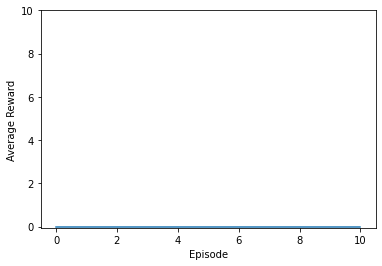

In [16]:
iterations = range(0, N_EPISODES, EPISODES_PER_LOG)
plt.plot(iterations, average_rewards)
plt.ylabel('Average Reward')
plt.xlabel('Episode')
plt.ylim(top=10)


# by RAM


In [4]:
# open the assualt environment (with image)
# AtariPreprocessing downsamples to 84x84, turns greyscale, and implements frame skipping
py_env = gym.make('Assault-ram-v0')
train_env = TFPyEnvironment(suite_gym.wrap_env(py_env))


In [107]:
q_net = QNetwork(train_env.observation_spec(),
                 train_env.action_spec(),

                 # The rescales the values to a range of [-1, 1]
                 preprocessing_layers=layers.Rescaling(scale=1./127.5,
                                                       offset=-1),

                 fc_layer_params=(32, 64, 64, 512, 7),

                 kernel_initializer=initializers.VarianceScaling(scale=2.0,
                                                                 mode='fan_in',
                                                                 distribution='truncated_normal'))

agent = DqnAgent(train_env.time_step_spec(),
                 train_env.action_spec(),
                 q_network=q_net,

                 epsilon_greedy=lambda: epsilon(
                     agent.train_step_counter.numpy()),

                 gamma=DISCOUNT_RATE,
                 optimizer=optimizers.SGD(LEARNING_RATE,
                                          MOMENTUM,
                                          nesterov=True))

agent.initialize()
agent.train = common.function(agent.train)


In [108]:
# implement replay buffer
replay_buffer = TFUniformReplayBuffer(agent.collect_data_spec,
                                      batch_size=1,
                                      max_length=REPLAY_BUFFER_MAX_LENGTH)

next_frame(train_env,
           RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec()),
           replay_buffer.add_batch)

experience_batches = iter(replay_buffer.as_dataset(num_steps=2,
                                                   sample_batch_size=BATCH_SIZE,
                                                   ).prefetch(3))


In [109]:
checkpointer = common.Checkpointer(path.join(getcwd(), 'checkpoint', 'ram'),
                                   max_to_keep=1, agent=agent,
                                   replay_buffer=replay_buffer)


In [111]:
rewards = []
average_rewards = []
for episode in range(N_EPISODES):
    time_step = train_env.reset()

    agent.train_step_counter.assign(0)
    n_step = agent.train_step_counter.numpy()

    episode_rewards = 0
    # Collect a few steps using collect_policy and save to the replay buffer.
    while n_step <= MAX_STEPS_PER_EPISODE and not time_step.is_last():
        if (DEBUG):
            # render the environment
            py_env.render()

        time_step = next_frame(train_env,
                               agent.collect_policy,
                               replay_buffer.add_batch)

        # Sample a batch of data from the buffer and update the agent's network.
        experience, _info = next(experience_batches)
        train_loss = agent.train(experience).loss

        ram_bits.append(time_step.observation.numpy()[0])

        episode_rewards += time_step.reward.numpy()[0]
        n_step = agent.train_step_counter.numpy()

    rewards.append(episode_rewards)

    if episode % EPISODES_PER_LOG == 0:
        average_rewards.append(sum(average_rewards[-10:]) / 10)
        print(f"\rEpisode {episode + 1}  Step {n_step}"
              f"\tReward - {time_step.reward.numpy()[0]:.5f}"
              f"\t(Avg10 - {(average_rewards[-1]):.5f})"
              f"\tLoss - {train_loss:.5f}"
              #   f"\tProgress {((((episode) * MAX_STEPS) + n_step)  * 100/ (MAX_STEPS * N_EPISODES)) :.1f}%"
              )

    if episode % EPISODES_PER_SAVE == 0:
        checkpointer.save(global_step=n_step)


py_env.close()
train_env.close()


# by screen & RAM


In [30]:
# open the assualt environment (with image)
# AtariPreprocessing downsamples to 84x84, turns greyscale, and implements frame skipping
py_env = AtariPreprocessing(gym.make('Assault-v0'),
                            frame_skip=FRAME_SKIP,
                            terminal_on_life_loss=True,
                            screen_size=84)


class CombinedEnv(py_environment.PyEnvironment):
    def __init__(self, env):
        super(CombinedEnv, self).__init__()
        self.env = env

    def _reset(self):
        return self.env.reset()

    def action_spec(self):
        return self.env.action_spec()

    def observation_spec(self):
        return {"screen": self.env.observation_spec(),
                "ram": ArraySpec(shape=(128,), dtype=np.float32)}

    def _step(self, action):
        time_step = self.env.step(action)
        return time_step._replace(observation={"screen": self.env.observation_spec(),
                                               "ram": py_env.env.ale.getRAM()})


train_env = TFPyEnvironment(CombinedEnv(suite_gym.wrap_env(py_env)))


In [34]:
screen_only_layers = Sequential([
    layers.Rescaling(scale=1./127.5, offset=-1),
    layers.Conv2D(32, (8, 8), (4, 4), activation='relu'),
    layers.Conv2D(64, (4, 4), (2, 2), activation='relu'),
    layers.Conv2D(64, (3, 3), (1, 1), activation='relu'),
    layers.Flatten(),
])

ram_only_layers = Sequential([
    layers.Rescaling(scale=1./127.5, offset=-1),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu')
])


q_net = QNetwork(train_env.observation_spec(),
                 train_env.action_spec(),

                 preprocessing_layers={"screen": screen_only_layers,
                                       "ram": ram_only_layers},
                 preprocessing_combiner=layers.Concatenate(axis=-1),

                 fc_layer_params=(512, 7),

                 kernel_initializer=initializers.VarianceScaling(scale=2.0,
                                                                 mode='fan_in',
                                                                 distribution='truncated_normal'))

agent = DqnAgent(train_env.time_step_spec(),
                 train_env.action_spec(),
                 q_network=q_net,

                 epsilon_greedy=lambda: epsilon(
                     agent.train_step_counter.numpy()),

                 gamma=DISCOUNT_RATE,
                 optimizer=optimizers.SGD(LEARNING_RATE,
                                          MOMENTUM,
                                          nesterov=True))

agent.initialize()
agent.train = common.function(agent.train)


In [48]:
# implement replay buffer
replay_buffer = TFUniformReplayBuffer(agent.collect_data_spec,
                                      batch_size=1,
                                      max_length=REPLAY_BUFFER_MAX_LENGTH)

random_policy = RandomTFPolicy(train_env.time_step_spec(),
                               train_env.action_spec())


time_step = train_env.current_time_step()
# action_step = random_policy.action(time_step)
# next_time_step = train_env.step(action_step.action)
# traj = trajectory.from_transition(time_step,
#                                   action_step,
#                                   next_time_step)
# replay_buffer.add_batch(traj)


# experience_batches = iter(replay_buffer.as_dataset(num_steps=2,
#                                                    sample_batch_size=BATCH_SIZE,
#                                                    ).prefetch(3))


ValueError: Could not pack sequence. Structure had 5 elements, but flat_sequence had 4 elements.  Structure: TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'ram': TensorSpec(shape=(128,), dtype=tf.float32, name=None),
                 'screen': BoundedTensorSpec(shape=(84, 84, 1), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8))},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}), flat_sequence: [<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, <tf.Tensor: shape=(1, 84, 84, 1), dtype=uint8, numpy=
array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]]], dtype=uint8)>].

In [24]:
checkpointer = common.Checkpointer(path.join(getcwd(), 'checkpoint', 'ram_and_screen'),
                                   max_to_keep=1, agent=agent,
                                   replay_buffer=replay_buffer)


In [27]:
rewards = []
average_rewards = []
for episode in range(N_EPISODES):
    time_step = train_env.reset()

    agent.train_step_counter.assign(0)
    n_step = agent.train_step_counter.numpy()

    episode_rewards = 0
    # Collect a few steps using collect_policy and save to the replay buffer.
    while n_step <= MAX_STEPS_PER_EPISODE and not time_step.is_last():
        if (DEBUG):
            # render the environment
            py_env.render()

        time_step = train_env.current_time_step()
        time_step._replace(observation={"screen": time_step,
                                        "ram": py_env.env.ale.getRAM()})

        action_step = agent.collect_policy.action({"screen": time_step,
                                                   "ram": py_env.env.ale.getRAM()})
        next_time_step = train_env.step(action_step.action)
        traj = trajectory.from_transition(time_step,
                                          action_step,
                                          next_time_step)

        # Add trajectory to the replay buffer
        replay_buffer.add_batch(traj)

        # Sample a batch of data from the buffer and update the agent's network.
        experience, _info = next(experience_batches)
        train_loss = agent.train(experience).loss

        episode_rewards += time_step.reward.numpy()[0]
        n_step = agent.train_step_counter.numpy()

    rewards.append(episode_rewards)

    if episode % EPISODES_PER_LOG == 0:
        average_rewards.append(sum(average_rewards[-10:]) / 10)
        print(f"\rEpisode {episode + 1}  Step {n_step}"
              f"\tReward - {time_step.reward.numpy()[0]:.5f}"
              f"\t(Avg10 - {(average_rewards[-1]):.5f})"
              f"\tLoss - {train_loss:.5f}"
              #   f"\tProgress {((((episode) * MAX_STEPS) + n_step)  * 100/ (MAX_STEPS * N_EPISODES)) :.1f}%"
              )

    if episode % EPISODES_PER_SAVE == 0:
        checkpointer.save(global_step=n_step)


py_env.close()
train_env.close()


TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 84, 84, 1), dtype=uint8, numpy=
array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]]], dtype=uint8)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>})


ValueError: <tf_agents.networks.q_network.QNetwork object at 0x0000017980731430>: `inputs` and `input_tensor_spec` do not have matching structures:
  .
vs.
  {'screen': ., 'ram': .}
Values:
  [[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]]
vs.
  {'screen': BoundedTensorSpec(shape=(84, 84, 1), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8)), 'ram': TensorSpec(shape=(128,), dtype=tf.float32, name=None)}.